## <center>Projet Nº6 - DETECTION DES FAUX BILLETS</center>

## Scénario

***Votre société de consulting informatique vous propose une nouvelle mission au ministère de l'Intérieur, dans le cadre de la lutte contre la criminalité organisée, à l'Office central pour la répression du faux monnayage. Votre mission si vous l'acceptez : créer un algorithme de détection de faux billets.***

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from visualization import *
import scipy.stats as st

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import sklearn.metrics as metrics

import warnings; warnings.simplefilter('ignore')

# Model
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFECV # On va slectioner les meilleru variable avec RFECV (cross validation)
from sklearn.feature_selection import RFE # On va utiliser le RFE pour pouvoir choisir les meiller variables du dataset
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split,  KFold, cross_val_score, cross_validate
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc, log_loss

# centering the image outputs
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    margin:auto;
}
.prompt 
    display:none;
}
}
</style>
""")

>- ***Importation de dataset***

In [2]:
df = pd.read_csv('./data/notes.csv')
df.head()

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.67,103.74,103.70,4.01,2.87,113.29
2,True,171.83,103.76,103.76,4.40,2.88,113.84
3,True,171.80,103.78,103.65,3.73,3.12,113.63
4,True,172.05,103.70,103.75,5.04,2.27,113.55


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    170 non-null    bool   
 1   diagonal      170 non-null    float64
 2   height_left   170 non-null    float64
 3   height_right  170 non-null    float64
 4   margin_low    170 non-null    float64
 5   margin_up     170 non-null    float64
 6   length        170 non-null    float64
dtypes: bool(1), float64(6)
memory usage: 8.3 KB


In [4]:
df.describe()

,diagonal,height_left,height_right,margin_low,margin_up,length
count,170.000000,170.000000,170.000000,170.000000,170.000000,170.000000
mean,171.940588,104.066353,103.928118,4.612118,3.170412,112.570412
std,0.305768,0.298185,0.330980,0.702103,0.236361,0.924448
min,171.040000,103.230000,103.140000,3.540000,2.270000,109.970000
25%,171.730000,103.842500,103.690000,4.050000,3.012500,111.855000
50%,171.945000,104.055000,103.950000,4.450000,3.170000,112.845000
75%,172.137500,104.287500,104.170000,5.127500,3.330000,113.287500
max,173.010000,104.860000,104.950000,6.280000,3.680000,113.980000


## <center>Mission 0</center>

**Afin d'introduire votre analyse, effectuez une brève description des données (analyses univariées et bivariées).**

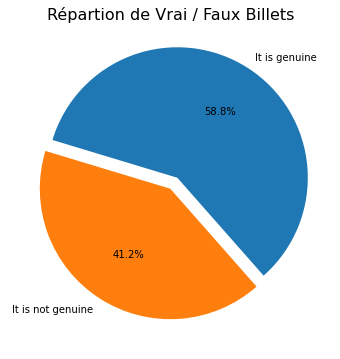

In [5]:
# On va faire un graphique pour verifier la répartition de vrai et faux billets dans le dataset.
fig, ax = plt.subplots(figsize=(10.5, 6))
labels = ['It is genuine', 'It is not genuine']
ratios = [.27, .56, .17]
explode = [.1, 0]
angle = -180 * ratios[0]
ax.pie(df['is_genuine'].value_counts(normalize=True), autopct='%1.1f%%', labels=labels, explode=explode, startangle=angle)
plt.title("Répartion de Vrai / Faux Billets", fontsize = 16)
#plt.savefig('repartition_vrai_faix.jpg', dpi=1200)
plt.show()

> ### Test d'adequation - Loi normal

Test de Shapiro : ShapiroResult(statistic=0.9889174699783325, pvalue=0.2044479101896286)


<Figure size 1080x720 with 0 Axes>

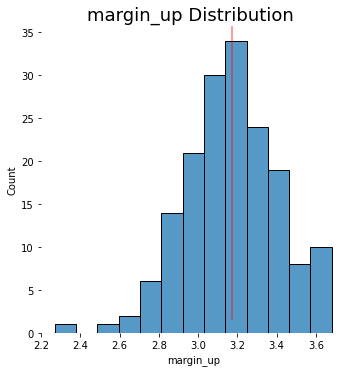

Test de Shapiro : ShapiroResult(statistic=0.9324630498886108, pvalue=3.714224874329375e-07)


<Figure size 1080x720 with 0 Axes>

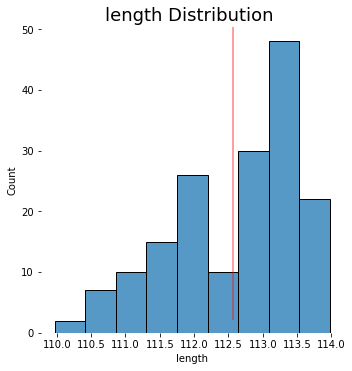

Test de Shapiro : ShapiroResult(statistic=0.9354014992713928, pvalue=6.225870947673684e-07)


<Figure size 1080x720 with 0 Axes>

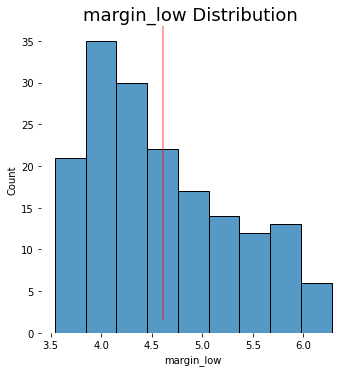

Test de Shapiro : ShapiroResult(statistic=0.9881214499473572, pvalue=0.16252844035625458)


<Figure size 1080x720 with 0 Axes>

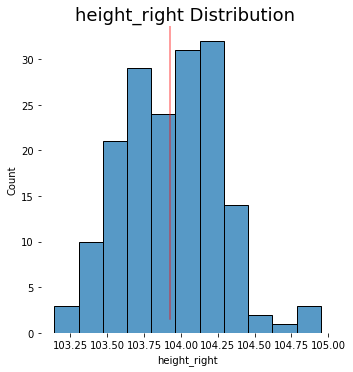

Test de Shapiro : ShapiroResult(statistic=0.9927234649658203, pvalue=0.5533665418624878)


<Figure size 1080x720 with 0 Axes>

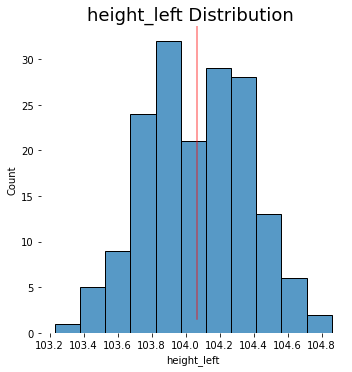

Test de Shapiro : ShapiroResult(statistic=0.9931768774986267, pvalue=0.6106324791908264)


<Figure size 1080x720 with 0 Axes>

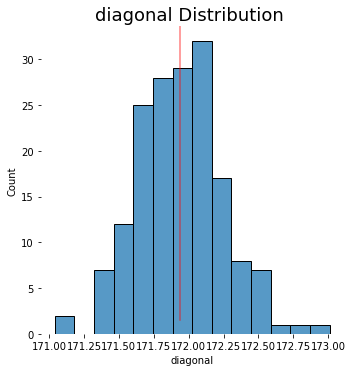

In [6]:
# On va plotter les differents variables et verifier si suit une loi normale.
# Pour la loi normale on fait un test de Shapiro.
histogram_plot('margin_up')
histogram_plot('length')
histogram_plot('margin_low')
histogram_plot('height_right')
histogram_plot('height_left')
histogram_plot('diagonal')

**grâce au test de Shapiro, les P-values nous ne permettent pas de rejetter l'hypothèse gaussienne sur les variables suivant (au niveau de test 5%):**
- Margin up ;
- Margin low ;
- Height right ;
- Height left ;
- Diagonal.

*Pour la variable* **Length, On obtien une P-value inférieur à 5%. On rejette l'hypothèse gaussienne.** 

> ### Analyse Bivariée

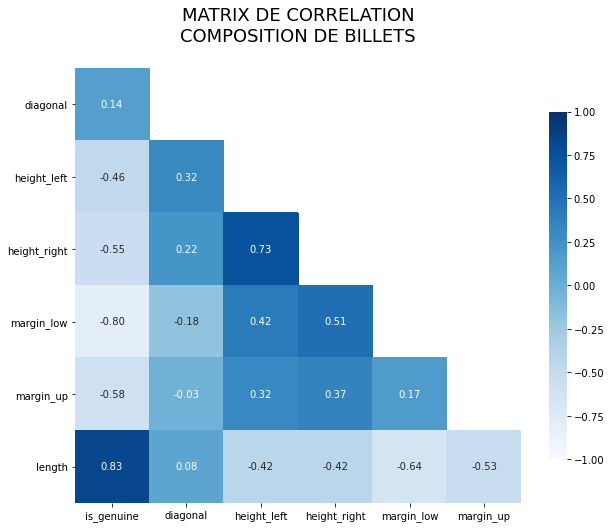

In [7]:
# On va faire une matrice de correlation.
# get correlations
df_corr = df.corr()

fig, ax = plt.subplots(figsize=(10, 8))
# mask
mask = np.triu(np.ones_like(df_corr, dtype=np.bool))
# adjust mask and df
mask = mask[1:, :-1]
corr = df_corr.iloc[1:,:-1].copy()
# plot heatmap
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='Blues',
           vmin=-1, vmax=1, cbar_kws={"shrink": .8})
# yticks
plt.yticks(rotation=0)

# title
title = 'MATRIX DE CORRELATION\nCOMPOSITION DE BILLETS\n'
plt.title(title, loc='center', fontsize=18)
plt.savefig('matrix_correlation.jpg', dpi=1200)
plt.show()

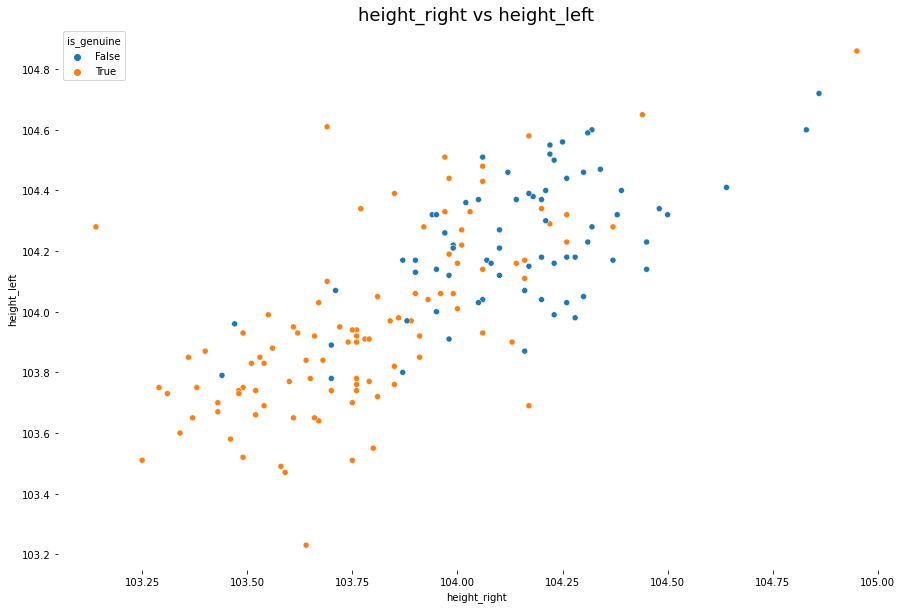

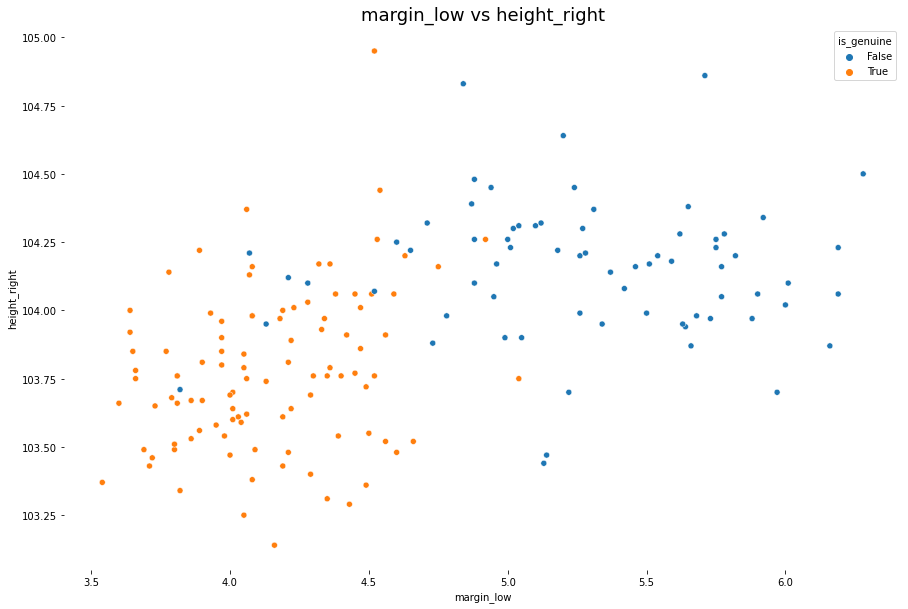

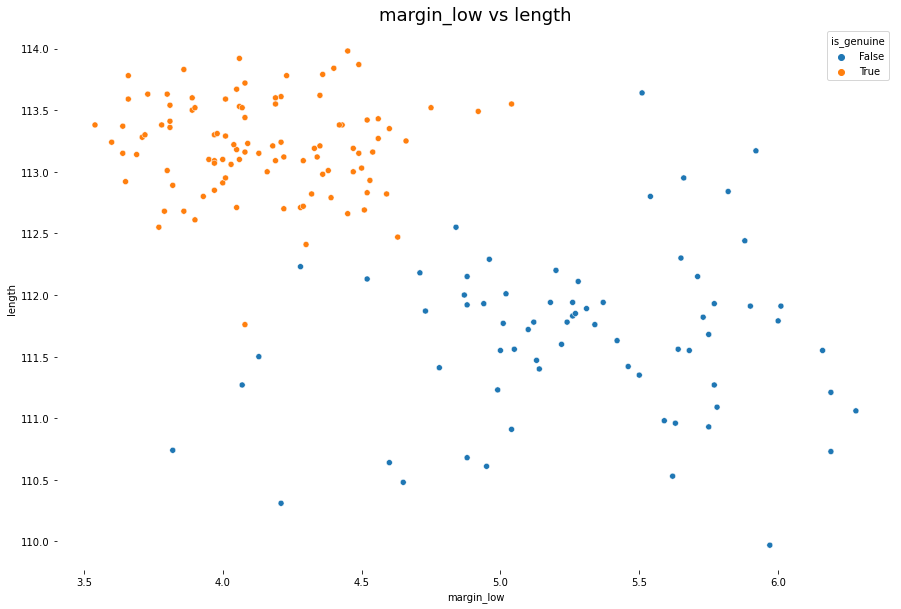

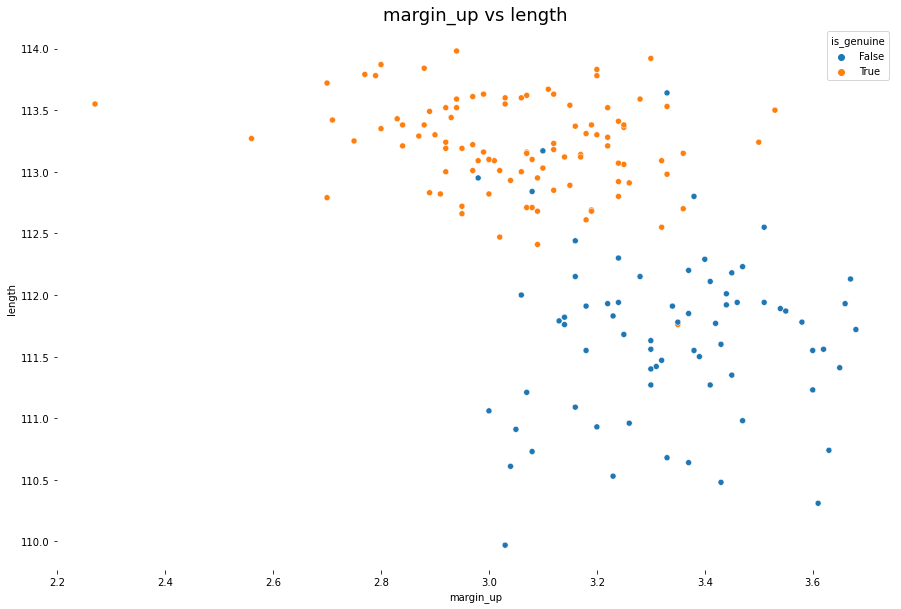

In [8]:
# On va faire les graphique avec scaterplot pour verifier la relation entre variable par aport à la variable 'is_genuine'
scatter_plot('height_right', 'height_left')
scatter_plot('margin_low', 'height_right')
scatter_plot('margin_low', 'length')
scatter_plot('margin_up', 'length')

**Le coefficient de correlation nous montrent plusieures corrélations :**

- height_right/height_left : 0.73
- margin_low/height_right : 0.51
- margin_low/length : -0.64
- margin_up/length : -0.53

**La variable is_genuine est très corrélé à :**

- length : 0.83
- margin_low : -0.80

**On constate que les faux billets ont des valuers médianes différents des vrai billets.**



## <center>Mission 1</center>

 ### Vous réaliserez une analyse en composantes principales de l'échantillon, en suivant toutes ces étapes :

- **analyse de l'éboulis des valeurs propres ;**
- **représentation des variables par le cercle des corrélations ;**
- **représentation des individus par les plans factoriels ;**
- **analyser de la qualité de représentation et la contribution des individus.**

***Pour chacune de ces étapes, commentez les résultats obtenus. La variable donnant la nature Vrai/Faux du billet sera utilisée comme variable illustrative.***

> ## PCA

In [9]:
# On va faire une copie du dataframe
acp_df = df.copy()
acp_df = acp_df.iloc[:, 1:] # on elimine la variable is_genuine
# Feature scaling
ss = StandardScaler()
df_scaled = pd.DataFrame(ss.fit_transform(acp_df))
df_scaled.columns = acp_df.columns
df_scaled.index = acp_df.index
#df_scaled.head()

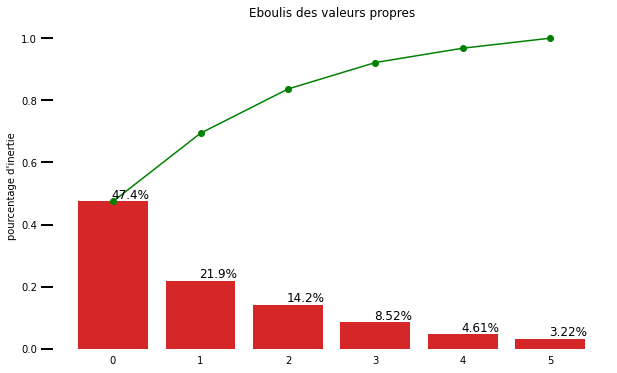

In [10]:
# On fait une function pour la PCA
def do_pca(data, n_components = None):
    pca = PCA(n_components)
    X_pca = pca.fit_transform(df_scaled)
    return pca, X_pca

pca, X_pca = do_pca(df_scaled)
display_scree_plot(pca)

**On remarque que les deux premiers axes cumulent 69.40% de l'inertie total.**

In [11]:
# On veux vérifier les nombre de components dont on a besoin pour pas perdre d'information
n_components = 5
values = pca.explained_variance_ratio_
cumulative_values = np.cumsum(values)
print("Avec {} components, {:.4f}% de la variance est expliquée".format(n_components, cumulative_values[n_components -1]*100))

Avec 5 components, 96.7787% de la variance est expliquée


In [12]:
# On choisi le nombre des components
n_components = 5
pca, X_pca = do_pca(df_scaled, n_components=n_components)

In [13]:
# On va faire une function pour savoir que variable a les plus de poid dans la PCA
def sort_pca_components(full_df, pca, nth_comp, top_n_feat = None):
    """
    Va retourner les variables avec le pois plus important et le pois mois important
    INPUTS:
        dull_df - dataframe avant la transfomation de la PCA 
        pca - le pca fitted au dataframe
        nth_comp - le nombre des components de la PCA à être analyzée
        top_n_feat - les nombres des feautures à être rétoruner
    OUTPUTS:
        top_pos_comp - features du nombre PCA component avec le plus haut positive pois
        top_neg_com - features du nombre PCA component avec le plus bas negative pois
    """
    # Obtenir la position des index de nth_comp. Index starts à 0
    dimension = nth_comp - 1
    # Obtenir pca compenents (pois) pour chaque dimmension et reshape 
    pca_comp_weights = pca.components_[dimension].reshape(1, len(pca.components_[dimension]))
    
    # Mettre PCA components dans à dataframe
    components = pd.DataFrame(np.round(pca_comp_weights, 4), columns = full_df.keys())
    index = ['Dimension ' + str(nth_comp)]
    components.index = index
    
    # Sortir les components dataframe par le top n positif pois
    top_pos_comp = components.sort_values(by=index, ascending = False, axis = 1)
    
    # Sortir les components dataframe par le top n negatif pois
    top_neg_comp = components.sort_values(by=index, ascending = True, axis = 1)
    
    if top_n_feat != None:
        top_pos_comp = top_pos_comp.iloc[:, :top_n_feat]
        top_neg_comp = top_neg_comp.iloc[:, :top_n_feat]
        
    return top_pos_comp, top_neg_comp

In [14]:
# On fait une function pour plotter les variables qui ont un poid positive et negative dans chaque dimention de la PCA
def plot_top_pca_weights(pos_df, neg_df):
    
    # Plot les variables avec leur pois comme une function des components
    pos_df = pos_df.transpose()
    pos_df.plot(kind = 'bar', legend = False)
    plt.xlabel(str(pos_df.columns.values[0]) + " Features")
    plt.ylabel('Pois des Variables')
    plt.title("Variables avec positif pois par  "+str(pos_df.columns.values[0]))
    
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    
    neg_df = neg_df.transpose()
    neg_df.plot(kind = 'bar', legend = False)
    plt.xlabel(str(pos_df.columns.values[0]) + " Features")
    plt.ylabel('Pois des Variables')
    plt.title("Variables avec negatif pois par  "+str(pos_df.columns.values[0]))
    
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    #plt.savefig('weight_2.jpg', dpi=1200)
    plt.show()

In [15]:
# variables avec le poid positve dans la prémier axe de la PCA
nth_comp = 1
top_pos_comp, top_neg_comp = sort_pca_components(df_scaled, pca, nth_comp, 6)
print("Top positive pois pour la prémiere component")
top_pos_comp

Top positive pois pour la prémiere component


,height_right,height_left,margin_low,margin_up,diagonal,length
Dimension 1,0.4918,0.4755,0.431,0.3525,0.0733,-0.4654


In [16]:
# variables avec un poid negatif dans la prémiere axe de la PCA
print("Top negative pois pour la prèmiere component")
top_neg_comp

Top negative pois pour la prèmiere component


,length,diagonal,margin_up,margin_low,height_left,height_right
Dimension 1,-0.4654,0.0733,0.3525,0.431,0.4755,0.4918


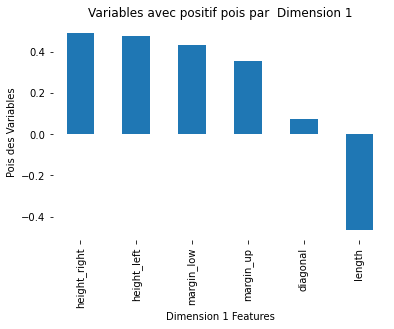

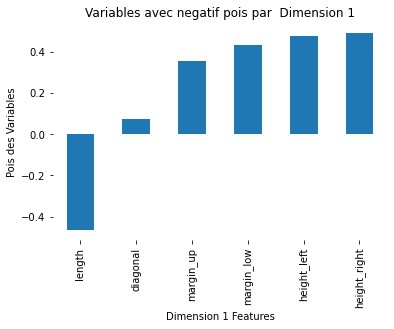

In [17]:
plot_top_pca_weights(top_pos_comp, top_neg_comp)

In [18]:
variance_explained = pca.explained_variance_ratio_[nth_comp - 1]
print("La prémiere component expique {:.4f}% de la variance".format(variance_explained*100))

La prémiere component expique 47.4479% de la variance


In [19]:
nth_comp = 2
top_pos_comp, top_neg_comp = sort_pca_components(df_scaled, pca, nth_comp, 6)
print("Top positive pois pour la deuxiéme component")
top_pos_comp

Top positive pois pour la deuxiéme component


,diagonal,height_left,length,height_right,margin_up,margin_low
Dimension 2,0.7796,0.3393,0.3145,0.2355,-0.1411,-0.3205


In [20]:
print("Top negative pois pour la deuxíeme component")
top_neg_comp

Top negative pois pour la deuxíeme component


,margin_low,margin_up,height_right,length,height_left,diagonal
Dimension 2,-0.3205,-0.1411,0.2355,0.3145,0.3393,0.7796


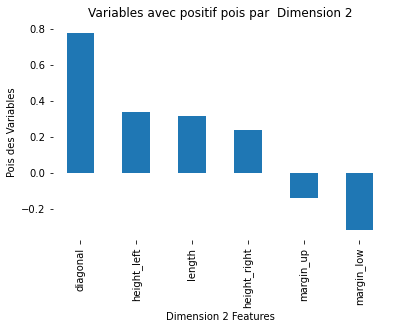

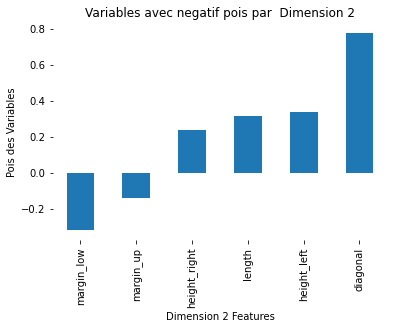

In [21]:
plot_top_pca_weights(top_pos_comp, top_neg_comp)

In [22]:
variance_explained = pca.explained_variance_ratio_[nth_comp - 1]
print("La deuxièmme component expique {:.4f}% de la variance".format(variance_explained*100))

La deuxièmme component expique 21.9571% de la variance


**On peut observer dans les graphiques les poids des variables dans les axes. Pour F1 on peut voir que les variables les plus important sont hight right, hight left, margin up and margin low et pour F2 est diagonal.**

> ## Cercle de Corrélation

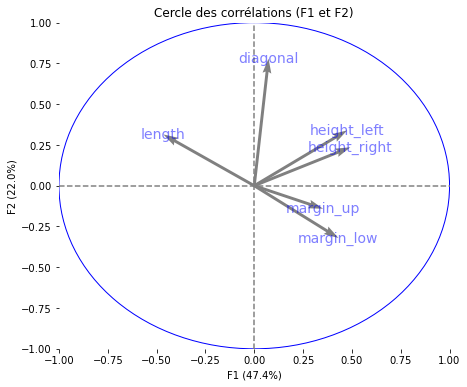

In [23]:
# Circle de correlation
pcs = pca.components_
display_circles(pcs, n_components, pca, [(0, 1)], labels = np.array(df_scaled.columns))

**On remarque une corrélation importante entre les hauteurs des billets et entre les marges**

***F1 va représenter le facteur "dimension global" et F2 représentera la variable diagonale***

> ## Plan Factoriel

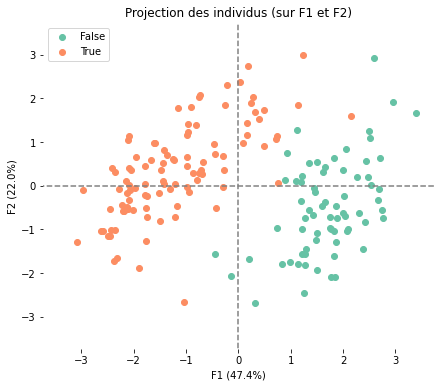

In [24]:
## graphique
sns.set_palette('Set2')
illustrative_var = np.array(df['is_genuine'].values)
display_factorial_planes(X_pca, n_components, pca, [(0, 1)], illustrative_var = illustrative_var)

**Les 2 nuages de points en function de "False/True" sont bien identifiés grâce à la projection F1 et F2**

*On observe que les variable qui ont les plus de contribution à* **F1 sont Hight_right, Hight_left, Margin_up et Margin_low** *et pour* **F2 est diagonal**.  

## <center>Mission 2</center>

- Appliquez un algorithme de classification, puis analysez le résultat obtenu.

- Visualisez la partition obtenue dans le premier plan factoriel de l'ACP, puis analysez-la.

> ### Classification par KMeans

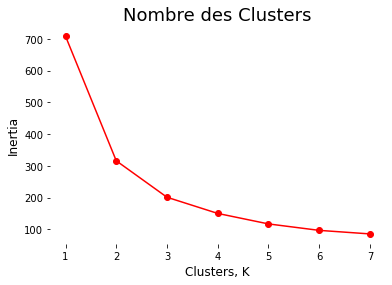

In [25]:
# On utilice K-Means avec un nombre de composant de 5 qu'on avait vu dans la PCA
pca = PCA(n_components = 5)
principalComponents = pca.fit_transform(df_scaled)
PCA_components = pd.DataFrame(principalComponents)

ks = range(1, 8)
inertias = []

for k in ks:
    model = KMeans(n_clusters = k)
    model.fit(PCA_components.iloc[:,:2])
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', color='red')
plt.title('Nombre des Clusters', fontsize=18)
plt.xlabel('Clusters, K',fontsize=12)
plt.ylabel('Inertia',fontsize=12)
plt.xticks(ks)

plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
#plt.savefig('clusters.jpg', dpi=1200)    
plt.show()

In [26]:
# Calcule Silhouette score
modelk = KMeans(n_clusters = 2)
modelk.fit(PCA_components.iloc[:,:2])
print(silhouette_score(PCA_components.iloc[:,:2], modelk.labels_, metric = 'euclidean'))

0.5044073076758975


In [27]:
# On va introduir les clusters dans le dataset
pred = modelk.predict(PCA_components.iloc[:,:2])
df_pred = pd.DataFrame(df)
df_pred['Cluster'] = pred

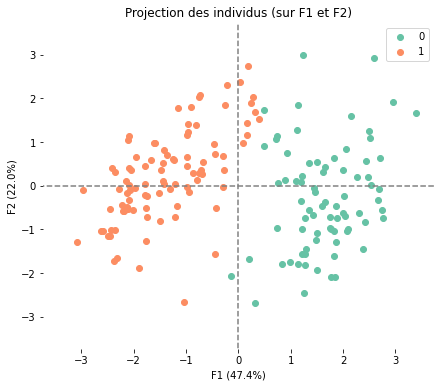

In [28]:
## graphique
sns.set_palette('Set2')
illustrative_var = np.array(df_pred['Cluster'].values)
display_factorial_planes(X_pca, n_components, pca, [(0, 1)], illustrative_var = illustrative_var)

In [29]:
print('AUROC : ', metrics.roc_auc_score(y_true=df['is_genuine'], y_score=pred))
conf = metrics.confusion_matrix(y_true = df['is_genuine'], y_pred=pred)
df_conf = pd.DataFrame(conf, columns=['réel Vrai',"réel Faux"])
df_conf.index = ['prédit Vrai',"prédit Faux"]
df_conf

AUROC :  0.9528571428571428


,réel Vrai,réel Faux
prédit Vrai,69,1
prédit Faux,8,92


**Nous avons une marge d'erreur de 4.71% dans le classement de notre dataset.**

*Nous avons* **8 vrai billets qui ont été classé comme des faux billets et 1 faux classé comme vrai**. *On remarque que ces points sont assez centraux et éloignés de leurs centroides respectifs.*

## <center>Mission 3</center>

Modélisez les données à l'aide d'une régression logistique. Grâce à celle-ci, vous créerez un programme capable d'effectuer une prédiction sur un billet, c'est-à-dire de déterminer s'il s'agit d'un vrai ou d'un faux billet. Pour chaque billet, votre algorithme de classification devra donner la probabilité que le billet soit vrai. Si cette probabilité est supérieure ou égale à 0.5, le billet sera considéré comme vrai. Dans le cas contraire, il sera considéré comme faux.

In [30]:
# Les vrais billets ont une valeur de 0 pour la prediction de notre modele
# Les faux billets ont une valeur de 1 pour la prédiction de notre modele
df_pred['is_genuine'] = df_pred['is_genuine'].apply(lambda x: 0 if x == True else 1)
df_pred['is_genuine'] = df_pred['is_genuine'].astype('category')

In [31]:
# On va utiliser Recursive feature Elimination (REF) de Sklearn 
# Pour choiser les variables le plus important pour le modele.
# On va fixer un nombre maximal des variables de 5.
X = df_pred.select_dtypes(np.number)
y = df_pred['is_genuine'].cat.codes

model = LogisticRegression()

rfe = RFE(model, 5)
         
rfe = rfe.fit(X, y)

print('Selected features: %s' % list(X.columns[rfe.support_]))

Selected features: ['height_right', 'margin_low', 'margin_up', 'length', 'Cluster']


Optimal number of features: 2
Selected features: ['margin_low', 'length']


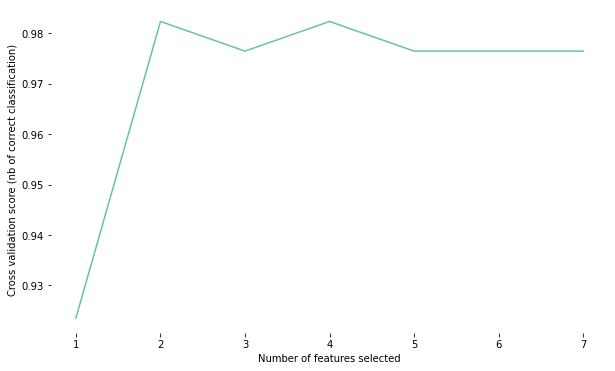

In [32]:
# On va utiliser Recursive feature Elimination with Cross-validation (RFECV) de Sklearn
# Pour obtenir les variables le plus important

rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=10, scoring='accuracy')
rfecv.fit(X, y)
print('Optimal number of features: %d' % rfecv.n_features_)
print('Selected features: %s' % list(X.columns[rfecv.support_]))

# Plot number of features VS cross-validation scores
plt.figure(figsize=(10, 6))
plt.xlabel('Number of features selected')
plt.ylabel('Cross validation score (nb of correct classification)')
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
#plt.savefig('b_features.jpg')
plt.show()

In [33]:
# On va choiser seulement les variables qu'on a obtenu grâce à RFECV
Selected_features = ['margin_low', 'length']

X = df_pred[Selected_features]
y = df_pred['is_genuine']

In [34]:
# La evaluation de Model est fait avec K-fold cross-validation, on utilise cross-val_score function()
logreg = LogisticRegression()

scores_accuracy = cross_val_score(logreg, X, y, cv=10, scoring = 'accuracy')
scores_log_loss = cross_val_score(logreg, X, y, cv=10, scoring = 'neg_log_loss')
scores_auc = cross_val_score(logreg, X, y, cv=10, scoring = 'roc_auc')
print('K-fold cross-validation results:')
print(logreg.__class__.__name__+" average accuracy is %2.3f" % scores_accuracy.mean())
print(logreg.__class__.__name__+" average log_loss is %2.3f" % -scores_log_loss.mean())
print(logreg.__class__.__name__+" average auc is %2.3f" % scores_auc.mean())

K-fold cross-validation results:
LogisticRegression average accuracy is 0.982
LogisticRegression average log_loss is 0.084
LogisticRegression average auc is 0.999


In [35]:
# La evaluation de Model est fait avec K-fold cross-validation, on utilise cross-validate function()
scoring = {'accuracy': 'accuracy', 'log_loss': 'neg_log_loss', 'auc': 'roc_auc'}

modelCV = LogisticRegression()

results = cross_validate(modelCV, X, y, cv=10, scoring=list(scoring.values()),
                        return_train_score=False)

print('K-fold cross-validation results:')
for sc in range(len(scoring)):
    print(modelCV.__class__.__name__+" average %s: %.3f (+/-%.3f)" % (list(scoring.keys())[sc],
                                                                     -results['test_%s' % list(scoring.values())[sc]].mean()
                                                                     if list(scoring.values())[sc] =='neg_log_loss'
                                                                     else results['test_%s' % list(scoring.values())[sc]].mean(), 
                                                                     results['test_%s' % list(scoring.values())[sc]].std()))

K-fold cross-validation results:
LogisticRegression average accuracy: 0.982 (+/-0.027)
LogisticRegression average log_loss: 0.084 (+/-0.044)
LogisticRegression average auc: 0.999 (+/-0.004)


In [36]:
# On rajoute plus des variables pour comparer le modele
cols = ['height_right', 'margin_low', 'margin_up', 'length', 'Cluster']

X = df_pred[cols]

scoring = {'accuracy': 'accuracy', 'log_loss': 'neg_log_loss', 'auc': 'roc_auc'}

modelCV = LogisticRegression()

results = cross_validate(modelCV, X, y, cv=10, scoring=list(scoring.values()),
                        return_train_score=False)

print('K-fold cross-validation results:')
for sc in range(len(scoring)):
    print(modelCV.__class__.__name__+" average %s: %.3f (+/-%.3f)" % (list(scoring.keys())[sc],
                                                                     -results['test_%s' % list(scoring.values())[sc]].mean()
                                                                     if list(scoring.values())[sc] =='neg_log_loss'
                                                                     else results['test_%s' % list(scoring.values())[sc]].mean(), 
                                                                     results['test_%s' % list(scoring.values())[sc]].std()))

K-fold cross-validation results:
LogisticRegression average accuracy: 0.976 (+/-0.039)
LogisticRegression average log_loss: 0.072 (+/-0.056)
LogisticRegression average auc: 0.996 (+/-0.009)


**On peut observer si on rajout plus des variables, le model va perdre un peu de l'accurasie.** *Les variables* **height_right', 'margin_up', 'Cluster'** *ne vont pas apportés plus d'information au model.*

In [37]:
# On utilise GridSearchCv pour evaluer le modele en utilisant plusieurs scores.

X = df_pred[Selected_features]

param_grid = {'C': np.arange(1e-05, 3, 0.1)}
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

gs = GridSearchCV(LogisticRegression(), return_train_score=True,
                 param_grid=param_grid, scoring=scoring, cv=10, refit='Accuracy')

gs.fit(X, y)
results = gs.cv_results_

print('Best params: ' + str(gs.best_estimator_))
print('Best params: ' + str(gs.best_params_))
print('Best score: ', gs.best_score_)

Best params: LogisticRegression(C=0.60001)
Best params: {'C': 0.60001}
Best score:  0.9823529411764707


> ## Model Testing

In [38]:
example = pd.read_csv('example.csv')
example

,diagonal,height_left,height_right,margin_low,margin_up,length,id
0,171.76,104.01,103.54,5.21,3.30,111.42,A_1
1,171.87,104.17,104.13,6.00,3.31,112.09,A_2
2,172.00,104.58,104.29,4.99,3.39,111.57,A_3
3,172.49,104.55,104.34,4.44,3.03,113.20,A_4
4,171.65,103.63,103.56,3.77,3.16,113.33,A_5


In [39]:
example = pd.DataFrame({'id': example.id,
                  'Proba_Vrai': gs.predict_proba(example[Selected_features])[:,0],
                  'Proba_Faux': gs.predict_proba(example[Selected_features])[:,1],
                  'Prediction': gs.predict(example[Selected_features])})
example                   

,id,Proba_Vrai,Proba_Faux,Prediction
0,A_1,0.021614,0.978386,1
1,A_2,0.015187,0.984813,1
2,A_3,0.052665,0.947335,1
3,A_4,0.923086,0.076914,0
4,A_5,0.988976,0.011024,0
